In [54]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [63]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_region_of_interest(img, vertices, color=[0, 0, 255], thickness=3):
    """
    Draw the interested region with the given vertices.
    
    Return None
    """
    cv2.line(img, tuple(vertices[0][0]), tuple(vertices[0][1]), color, thickness)
    cv2.line(img, tuple(vertices[0][1]), tuple(vertices[0][2]), color, thickness)
    cv2.line(img, tuple(vertices[0][2]), tuple(vertices[0][3]), color, thickness)
    cv2.line(img, tuple(vertices[0][3]), tuple(vertices[0][0]), color, thickness)

def cal_slope(x1, y1, x2, y2):
    """
    Calculate the slop given the two points (x1, y1) and (x2, y2)
    
    Returns, float
    """
    slope_max = 1000
    if x1 == x2:
        print("""WARNING: max slope returned from the following points ({x1}, {y1}), ({x2}, {y2})""".format(
        x1=x1, y1=y1, x2=x2, y2=y2))
        return slope_max
    else:
        return (y1 - y2) / (x1 - x2)
    
def find_x(k, b, y):
    """
    Given a line specified by slope k and intercept b and the y coordinate
    on the line, returns the cooresponding x coordinate. x is rounded to an integer
    in order to make cv2.line() function work.
    """
    if k == 0:
        raise ValueError('slope cannot be zero!')
    else:
        x = (y - b) / k
        return int(round(x))


def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # used to collect the left and right lane boundaries
    
    # the max and min of extrapolated y coordniate.
    # in this case, it is the bottum and the middle of the image.
    y_max = 720 
    y_min = 360
    slope_threshold = 0.3

    
    x_positive_slope = []
    y_positive_slope = []
    x_negtive_slope = []
    y_negtive_slope = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = cal_slope(x1, y1, x2, y2)
            if (slope > slope_threshold) or (slope < -slope_threshold):
                    # print(slope)
                    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

#             if slope > slope_threshold:
#                 x_positive_slope.extend([x1, x2])
#                 y_positive_slope.extend([y1, y2])

#             elif slope < -slope_threshold:
#                 x_negtive_slope.extend([x1, x2])
#                 y_negtive_slope.extend([y1, y2])
                
#     # extrapolate the slopes
#     pos_coefs = np.polyfit(x_positive_slope, y_positive_slope, deg=1)
#     neg_coefs = np.polyfit(x_negtive_slope, y_negtive_slope, deg=1)
    
    
#     # find the end points
#     x_max_pos = find_x(pos_coefs[0], pos_coefs[1], y_max)
#     x_min_pos = find_x(pos_coefs[0], pos_coefs[1], y_min)
    
#     x_max_neg = find_x(neg_coefs[0], neg_coefs[1], y_max)
#     x_min_neg = find_x(neg_coefs[0], neg_coefs[1], y_min)

        
#     cv2.line(img, (x_max_pos, y_max), (x_min_pos, y_min), color, thickness)
#     cv2.line(img, (x_max_neg, y_max), (x_min_neg, y_min), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [64]:
def lane_detection_pipeline(image, canny_params, hough_params, vertices):
    
    # unpack hyper-params
    kernel_size, canny_low_threshold, canny_high_threshold = canny_params
    rho, theta, hough_threshold, min_line_len, max_line_gap = hough_params
    
    gray_image = grayscale(image)
    blur_gray_image = cv2.GaussianBlur(gray_image,(kernel_size, kernel_size),0)

    # edge finding should go before image segementation because 
    # segementation might change the found edges.
    edge_image = canny(blur_gray_image, low_threshold=canny_low_threshold, high_threshold=canny_high_threshold)

    segement_image = region_of_interest(edge_image, vertices=vertices)
    
    plt.imshow(segement_image)
    lines = hough_lines(segement_image, rho=rho, theta=theta, threshold=hough_threshold,
                         min_line_len=min_line_len, max_line_gap=max_line_gap)
    
    # draw intersted area
    draw_region_of_interest(lines, vertices)

    # draw the detected lane on top of the original image
    final_image = weighted_img(lines, image)
    return final_image.copy()


# then save them to the test_images_output directory.

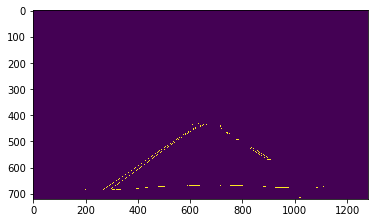

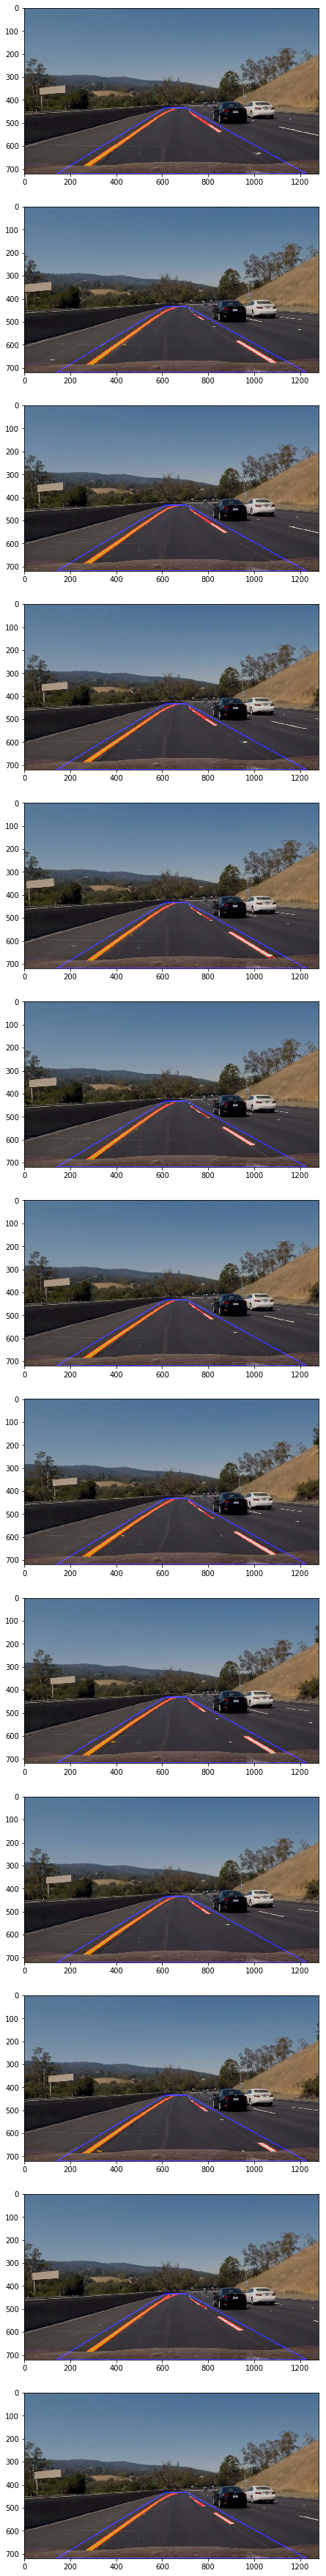

In [70]:
kernel_size = 5
canny_low_threshold = 50
canny_high_threshold = 200

canny_params = (kernel_size, canny_low_threshold, canny_high_threshold)

rho = 1
theta = np.pi / 180
hough_threshold = 30
min_line_len = 25
max_line_gap = 40

hough_params = (rho, theta, hough_threshold, min_line_len, max_line_gap)

y_full = 720
x_full = 1280

# [upper left, upper right, lower right, lower left]
vertices = np.array([[(0.48*x_full, 0.6*y_full),
                      (0.55*x_full, 0.6*y_full),
                      (0.96*x_full, y_full),
                      (0.11*x_full, y_full)]],
                   dtype=np.int32)

image_paths = os.listdir("debug_files/frames_challenge/")[:]
results = []

for image_path in image_paths:
    
    image_path = 'debug_files/frames_challenge/' + image_path
    # load image
    image = mpimg.imread(image_path)
    final_image = lane_detection_pipeline(image, canny_params, hough_params, vertices)
    results.append(final_image)
    
# show results
ax = []
fig = plt.figure(figsize=(48, 64))
rows = len(results)
cols = 1

for i, res in enumerate(results):
    ax.append(fig.add_subplot(rows, cols, i+1))
    plt.imshow(res)
plt.show()

## Video

In [71]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = lane_detection_pipeline(image, canny_params, hough_params, vertices)
    return result

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:09<00:00, 25.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 7.4 s, sys: 1.08 s, total: 8.48 s
Wall time: 10.8 s


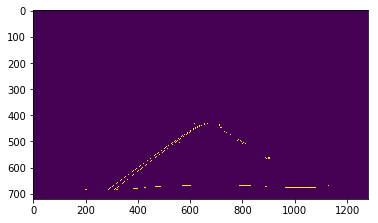

In [72]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [73]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))